In [67]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import yfinance as yf

In [68]:
sp500 = yf.download('^GSPC', start='2021-01-01', end='2023-08-31')['Close'].pct_change().dropna()
sp500 = sp500.reset_index()

[*********************100%%**********************]  1 of 1 completed


In [69]:
sp500_returns = sp500['Close'].values
sp500_returns

array([ 7.08259516e-03,  5.70984275e-03,  1.48474038e-02,  5.49186269e-03,
       -6.55475090e-03,  4.15788447e-04,  2.27564174e-03, -3.75345119e-03,
       -7.19002798e-03,  8.13637952e-03,  1.39356254e-02,  3.16723308e-04,
       -3.01061166e-03,  3.61583894e-03, -1.48883375e-03, -2.56778837e-02,
        9.76062598e-03, -1.93114752e-02,  1.60517676e-02,  1.38982235e-02,
        1.00876908e-03,  1.08533222e-02,  3.89749516e-03,  7.39934836e-03,
       -1.11352499e-03, -3.45184932e-04,  1.66245516e-03,  4.71103311e-03,
       -5.69272418e-04, -3.20402009e-04, -4.41583563e-03, -1.85489664e-03,
       -7.73283946e-03,  1.25631812e-03,  1.13516138e-02, -2.44788075e-02,
       -4.75021417e-03,  2.37907635e-02, -8.08085169e-03, -1.30662219e-02,
       -1.34172139e-02,  1.94959682e-02, -5.35923103e-03,  1.41546423e-02,
        6.03031334e-03,  1.03954870e-02,  1.01539850e-03,  6.49192130e-03,
       -1.56968373e-03,  2.87938213e-03, -1.47605393e-02, -6.02703975e-04,
        7.02511808e-03, -

In [70]:
# Hawkes process

def log_likelihood(x, t):
    lmbda, alpha, beta = x
    if (beta < alpha):
        return +np.inf
    n = len(t)
    a1 = np.zeros(n)
    for i in range(1, n):
        a1[i] = np.exp(-beta*(t[i]-t[i-1]))*(a1[i-1] + 1)
    l = 0.0
    l += -t[n-1]*lmbda 
    l += np.sum(np.exp(-beta*(t[n-1] - t)) - 1)*alpha/beta 
    l += np.sum(np.log(lmbda + alpha*a1))
    return -l

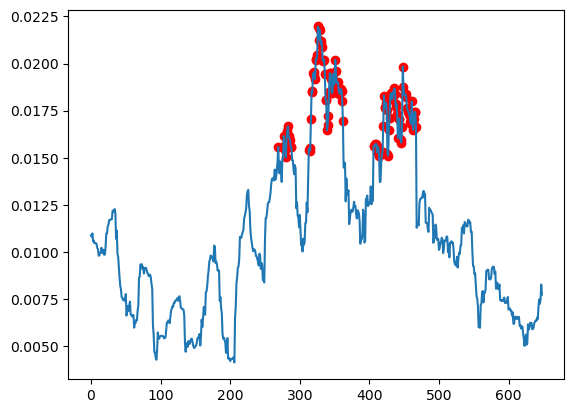

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 265.59045951280734
             x: [ 1.787e-01  1.370e-03  1.370e-03]
           nit: 103
          nfev: 196
 final_simplex: (array([[ 1.787e-01,  1.370e-03,  1.370e-03],
                       [ 1.787e-01,  1.370e-03,  1.370e-03],
                       [ 1.787e-01,  1.371e-03,  1.371e-03],
                       [ 1.787e-01,  1.370e-03,  1.370e-03]]), array([ 2.656e+02,  2.656e+02,  2.656e+02,  2.656e+02]))


In [71]:
rolling_vol = sp500['Close'].rolling(window=20).std().dropna().values
events = []
events_val = []
for i in range(1, len(rolling_vol)):
    if rolling_vol[i] > 0.015:
        events.append(i)
        events_val.append(rolling_vol[i])

plt.plot(rolling_vol)
plt.scatter(events, events_val, color='red')
plt.show()

from scipy.optimize import minimize

t = np.array(events)
x0 = np.array([0.1, 0.001, 0.1])
res = minimize(log_likelihood, x0, args=(t), method='Nelder-Mead')
res.x
print(res)

In [72]:
print(res.x)

[0.1787419  0.00137043 0.00137044]


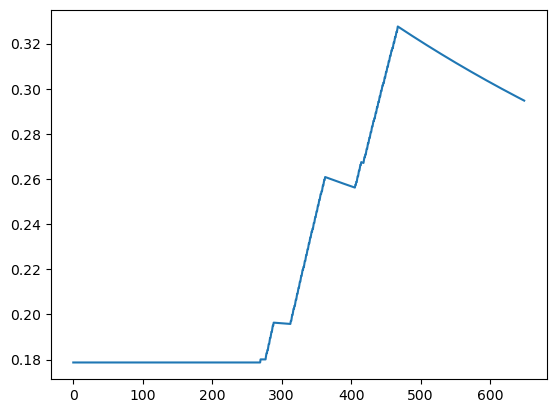

In [73]:
def mu(x, t):
    lmbda, alpha, beta = x
    return alpha * np.exp(-beta*t)

def intensity(x, tk, t):
    lmbda, alpha, beta = x
    n = len(tk)
    a = 0
    i = 0
    while i < n and tk[i] < t:
        a += np.exp(-beta*(t-tk[i]))
        i += 1
    return lmbda + alpha*a

T = len(rolling_vol)
t = np.linspace(0, T, 1000)
intensity_values = [intensity(res.x, events, tt) for tt in t]
plt.plot(t, intensity_values)
plt.show()